# Brain Tumor Detection Using CNN and Pretrained Image classification Models

## Introduction

In this project, I am using a Deep Learning Technique known as Convolutional Neural Networks (CNN) to create a model that can identify brain tumors from medical images. My approach involves using the ResNet50V2, a powerful model that has already been trained on a large collection of images called ImageNet, to boost the model's speed and accuracy in spotting brain tumors.

## Data Source

The images I used for this project come from the  "[Brain Tumor Dataset](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset)" hosted on Kaggle. This dataset contains several MRI scans of brains, which are crucial for recognizing brain tumors.
## Setting Up the Model

### Importing Libraries and Setting Parameters


In [1]:
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import models
import tensorflow.keras.layers as L

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from ipywidgets import widgets, interact
import random
import cv2
import os


In [ ]:
# Using GPU Mixed Precision to make the training faster
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


## Implementing the CNN with Transfer Learning
I shall be using the ResNet50V2 model with the 'imagenet' weights for feature extraction. This is a commonly used Transfer Learning technique. After this model provides an output, in order to reduce dimensionality, the output shall be passed through a Global Average Pooling Layer.

In [3]:
#Adjust image size and seed for model training
image_size = (512, 512)
Seed = 42

In [4]:
tumor_Net1 = applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*image_size, 3),
)
feature_extractor = keras.models.Sequential([
    L.Input(shape=(*image_size, 3)),
    tumor_Net1,
    L.GlobalAveragePooling2D(),
])

## EDA (Exploratory Data Analysis)
Basic Data Analysis before proceeding with Model Training

In [5]:
# Reading the direction for the images
main_dir = "D:\\Colorado\\Deep Learning\\Final Project\\Brain Tumor Data Set"
tumor_dir = "D:\\Colorado\\Deep Learning\\Final Project\\Brain Tumor Data Set\\Brain Tumor"
healthy_dir = "D:\\Colorado\\Deep Learning\\Final Project\\Brain Tumor Data Set\\Healthy"

# Reading the csv file that contain the data about the images
df = pd.read_csv("D:\\Colorado\Deep Learning\\Final Project\\Brain Tumor Data Set\\metadata.csv")
df = df.drop(df.columns[0], axis=1)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [6]:
# Showing the main charactaristics of each column in the dataset using an interactable widget
@interact(column = df.columns)
def column_info(column):
    print("*" * 10, column, "*" * 10)
    display(df[column].value_counts())
    print("-" * 30)
    display(df[column].describe())
    print("=" * 40)

interactive(children=(Dropdown(description='column', options=('image', 'class', 'format', 'mode', 'shape'), va…

In [7]:
#Create 2 seperate lists for tumor and healthy brains to help with basic visualizations
tumor1 = []
healthy1 = []

for i in range(len(df)):
    img = df.iloc[i,0]
    if df.iloc[i,1] == 'tumor':
        tumor1.append(os.path.join(tumor_dir, img))
    else:
        healthy1.append(os.path.join(healthy_dir, img))

### Plotting 7 random images from each of the two classes

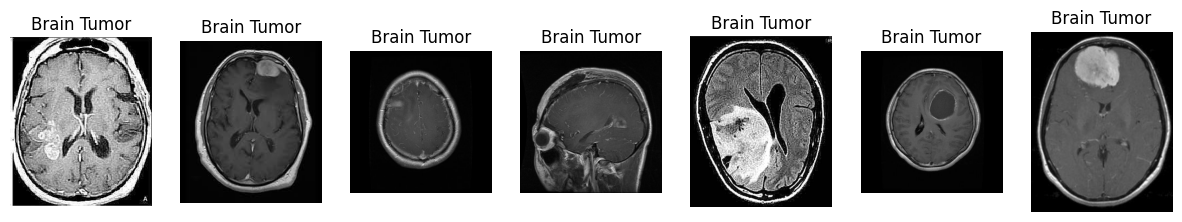

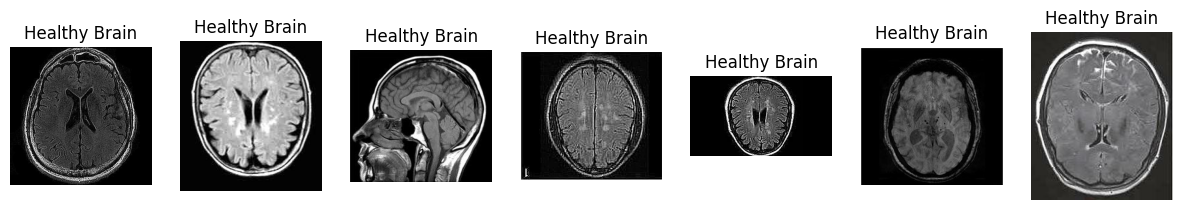

In [8]:
def plot_images(data , image_title, num_of_images):
    plt.figure(figsize=(15,10))
    for i in range(num_of_images):
        random_image = random.choice(data)
        random_image = cv2.imread(random_image)

        if len (random_image.shape) == 3:
            random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
        if len (random_image.shape) == 2:
            random_image = cv2.cvtColor(random_image, cv2.COLOR_GRAY2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title(image_title)
    
    plt.show()

plot_images(tumor1,'Brain Tumor',7)
plot_images(healthy1 ,'Healthy Brain',7)

### Insights from the Pie Chart
The pie chart reveals that 54% of the dataset consists of 'Tumor' images, while the remaining 45.4% are labeled as 'Normal'. This distribution provides a substantial amount of data for both categories

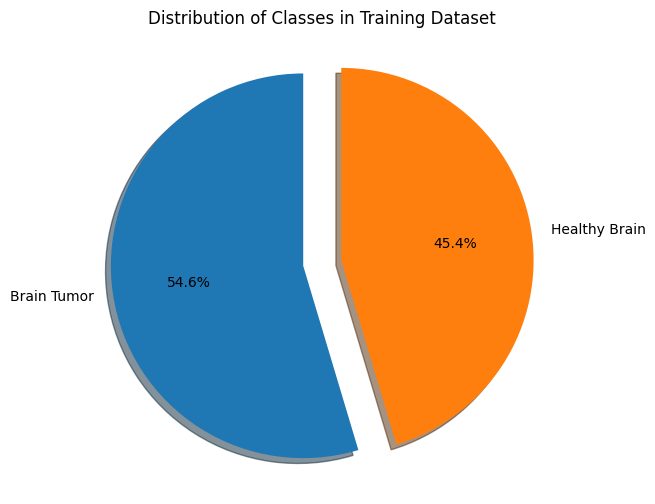

In [9]:
def make_pie(data,labels,title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')  
    plt.title('Distribution of Classes in Training Dataset')
    plt.show()
    
data = [len(tumor1),len(healthy1)]
labels = ['Brain Tumor','Healthy Brain']
explode = [0.1] * len(labels)  
#colors = ['red','blue']
make_pie(data,labels,'Categories distribution')

## Preparing the Data
I prepare the dataset by loading images from the directory specified in the Kaggle dataset. I set aside 20% of the images for validation to train the model on 80% of the data and validate it on the remaining 20%.

In [10]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory= main_dir,

    color_mode="rgb",
    image_size=image_size,
    crop_to_aspect_ratio=False,
    #pad_to_aspect_ratio=True,
    interpolation="bilinear",

    seed= Seed,
    shuffle=True,
    validation_split=0.2,
    subset="both",

    batch_size=16,
)
print("Class labels:", train_ds.class_names)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Using 902 files for validation.
Class labels: ['Brain Tumor', 'Healthy']


# Extracting Features from Images and dividing the data into training and validation data using a Pre-trained Model

This guide outlines the process of extracting features from images using a pre-trained model. This approach is crucial for transforming raw image data into a format that is more suitable for training machine learning models.


In [11]:
def extract_features(model, dataset):
    feature_list = []
    label_list = []
    for images, labels in tqdm(dataset):
        features = model(images)
        feature_list.append(features.numpy())
        label_list.append(labels.numpy())
    features = np.concatenate(feature_list)
    labels = np.concatenate(label_list)
    return features, labels
train_x, train_y = extract_features(feature_extractor, train_ds)
val_x, val_y = extract_features(feature_extractor, val_ds)

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

# Setting Up a Binary Classifier with Keras

This section describes the setup of a binary classifier using the Keras framework, designed for tasks such as distinguishing between two classes (e.g., tumor vs. normal). The classifier uses a dense layer with sigmoid activation.


In [12]:
bin_classifier = keras.models.Sequential([
    L.Input(shape=train_x.shape[1:]),
    L.Dense(units=1, activation='sigmoid'),
])
bin_classifier.compile(
    optimizer='adam',
    loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'],
)

# Implementing Training Callbacks in Keras

In order to  optimize the training process of this convoluted neural network, 2 kinds of callbacks provided by Keras Library are used. These callbacks dynamically adjust parameters during the training process, such as stopping training early under certain conditions or modifying the learning rate if the model's performance ceases to improve.

## Callbacks Used

### EarlyStopping
- **Purpose**: Prevents overfitting by terminating training if the validation accuracy does not improve for a defined number of epochs.
- **Monitor**: `val_accuracy` is observed to decide whether to stop training, indicating the model's performance on the validation set.
- **restore_best_weights**: This ensures that the model reverts to the weights from its best epoch (in terms of validation accuracy) once training is stopped.
- **Patience**: Defines how long the algorithm shall wait after the previous monitored metric improvement. Set to 60 epochs

### ReduceLROnPlateau
- **Purpose**: To adjust the learning rate dynamically during training if the validation accuracy stops improving, which can help the model converge to a minimum more efficiently.
- **Monitor**: Observes the `val_accuracy` to determine when to reduce the learning rate.
- **Factor**: The learning rate will be multiplied by the factor specified. Here, it is 0.8, meaning the learning rate reduced by 20%.
- **Patience**: Set to 15 epochs, which specifies the number of epochs to wait before reducing the learning rate after the monitored metric has stopped improving.


In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        restore_best_weights=True,
        patience=60,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.8,
        patience=15,
    )
]


# Training the Binary Classifier Model


In [14]:
log = bin_classifier.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=500,
    callbacks=callbacks,
)

Epoch 1/500
113/113 [==============================] - 1s 5ms/step - loss: 3.2531 - accuracy: 0.5731 - val_loss: 1.3534 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 2/500
113/113 [==============================] - 0s 4ms/step - loss: 0.9730 - accuracy: 0.6575 - val_loss: 0.7345 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 3/500
113/113 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.7204 - val_loss: 0.3892 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 4/500
113/113 [==============================] - 0s 4ms/step - loss: 0.4324 - accuracy: 0.7658 - val_loss: 0.4564 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 5/500
113/113 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.7384 - val_loss: 0.3417 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 6/500
113/113 [==============================] - 0s 4ms/step - loss: 0.4385 - accuracy: 0.7849 - val_loss: 0.3689 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 7/500
113/113 [==============================] - 0s 4ms/st

# Visualizing Model Training Performance


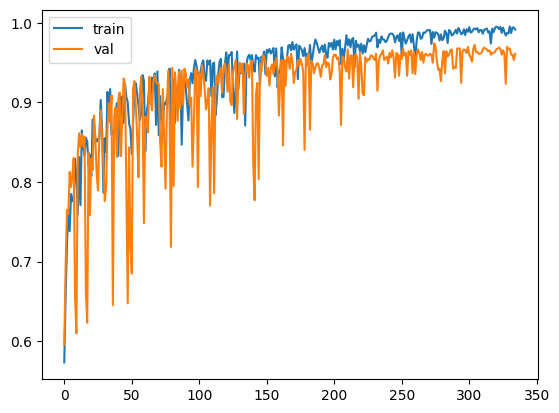

In [15]:
plt.plot(log.history["accuracy"], label='train')
plt.plot(log.history["val_accuracy"], label='val')
plt.legend()
plt.show()

### Training Accuracy: 99.17%
### 
### Validation Accuracy: 96.12%
### 


# Integrating Classifier with Feature Extractor


In [16]:
feature_extractor.add(bin_classifier)
model = feature_extractor
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


# Compiling the Integrated Model

In [17]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'],
)

# Training the Integrated Model

After setting up and compiling the integrated model, the final step before using it for predictions or further evaluations is to train it.

In [18]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
)

Epoch 1/10
226/226 [==============================] - 62s 241ms/step - loss: 0.6312 - accuracy: 0.8873 - val_loss: 0.1198 - val_accuracy: 0.9534
Epoch 2/10
226/226 [==============================] - 51s 226ms/step - loss: 0.0473 - accuracy: 0.9690 - val_loss: 0.0348 - val_accuracy: 0.9767
Epoch 3/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0192 - accuracy: 0.9867 - val_loss: 0.0322 - val_accuracy: 0.9856
Epoch 4/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0119 - accuracy: 0.9928 - val_loss: 0.0474 - val_accuracy: 0.9823
Epoch 5/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0053 - accuracy: 0.9942 - val_loss: 0.0350 - val_accuracy: 0.9867
Epoch 6/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0036 - accuracy: 0.9972 - val_loss: 0.0514 - val_accuracy: 0.9823
Epoch 7/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0047 - accuracy: 0.9961 - val_loss: 0.0353 - val_ac

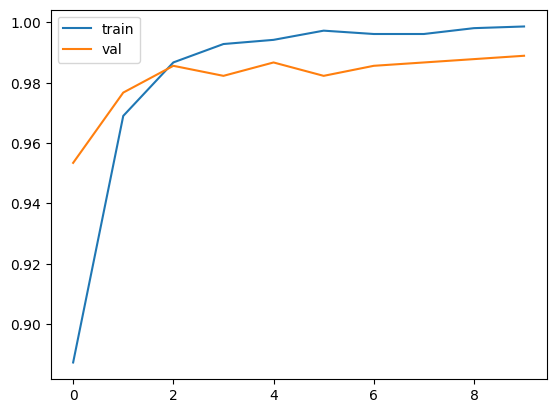

In [19]:
plt.plot(model.history.history["accuracy"], label='train')
plt.plot(model.history.history["val_accuracy"], label='val')
plt.legend()
plt.show()

# Conclusion

In this project, I successfully developed a machine learning model that can detect brain tumors from images. I achieved an accuracy score of 99.86% on training data and 98.89% on validation data. I used the ResNet50V2 model, known for its powerful image processing capabilities, as the foundation for extracting features from brain scans, thereby implementing transfer learning in this projct.I also added a custom classifier on top of the ResNet50V2 feature extractor. This classifier is tailored to distinguish between normal and tumor images effectively.

I also made sure the model was finely tuned for our specific needs. I chose an optimizer and a loss function which are preferred for dealing with unbalanced data, which is common in medical images where one class (like tumors) might be rarer than another (like healthy organs). During training, I used techniques like EarlyStopping and ReduceLROnPlateau to dynamically stop the training process as well as adjust the learning rate to get the best results and prevent overfitting.

Overall, I believe this project highlights the potential advanced techniques like convolutional neural networks (CNNs) and transfer learning have in medical studies and medical diagnostics.